In [43]:
import numpy as np
import pandas as pd
import random
import gym
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Constants
Q_MIN = 20                     # Minimum order size unit
MAX_ORDER_SIZE = 20000        # Total size to buy
MAX_TIME_SECONDS = 1800       # 30 minutes in seconds
DEPTH_LEVELS = 5              # Use top-5 levels in LOB
ALPHA_DEPTH_PENALTY = 2.0     # Penalty multiplier
FINAL_PENALTY_PER_SHARE = 5.0 # Penalty if not completed

# Action space mapping
ACTION_MAPPING = {
    0: 0,
    1: 1 * Q_MIN,
    2: 2 * Q_MIN,
    3: 3 * Q_MIN,
    4: 4 * Q_MIN
}

Using device: cpu


### **ENVIRONMENT CREATION**

In [45]:
class OptimalExecutionEnv(gym.Env):
    def __init__(self, initial_inventory=MAX_ORDER_SIZE, max_time=MAX_TIME_SECONDS):
        super().__init__()
        self.initial_inventory = initial_inventory
        self.max_time = max_time
        self.current_step = 0
        self.inventory = initial_inventory
        self.arrival_price = 100.00  # Store initial price for implementation shortfall

        # Mock LOB - in practice, fetch from ABIDES or a data feed
        self.best_bid = 100.00
        self.best_ask = 100.02
        self.volume_bid = np.ones(DEPTH_LEVELS) * 5000
        self.volume_ask = np.ones(DEPTH_LEVELS) * 5000

        # Add some randomness to market evolution
        self.price_volatility = 0.001

        # Observation: [%time left, %inventory left, imbalance1..5, bid, ask]
        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(2 + DEPTH_LEVELS + 2,), dtype=np.float32
        )

        # Discrete action: do nothing or consume Qmin*k (k=1..4)
        self.action_space = gym.spaces.Discrete(5)

    def reset(self):
        self.current_step = 0
        self.inventory = self.initial_inventory
        self.best_bid = 100.00
        self.best_ask = 100.02
        self.arrival_price = self.best_ask  # Set arrival price
        # Reset volumes with some randomness
        self.volume_bid = np.random.uniform(3000, 7000, DEPTH_LEVELS)
        self.volume_ask = np.random.uniform(3000, 7000, DEPTH_LEVELS)
        return self._get_state()

    def _update_market(self):
        """Simple market evolution with random walk"""
        price_change = np.random.normal(0, self.price_volatility)
        self.best_bid += price_change
        self.best_ask += price_change
        
        # Update volumes slightly
        self.volume_bid += np.random.normal(0, 100, DEPTH_LEVELS)
        self.volume_ask += np.random.normal(0, 100, DEPTH_LEVELS)
        self.volume_bid = np.maximum(self.volume_bid, 1000)  # Minimum volume
        self.volume_ask = np.maximum(self.volume_ask, 1000)

    def _get_state(self):
        pct_time_left = max(0, 1 - (self.current_step / self.max_time))
        pct_inventory_left = self.inventory / self.initial_inventory

        imbalance = self.volume_bid[:DEPTH_LEVELS] / (
            self.volume_bid[:DEPTH_LEVELS] + self.volume_ask[:DEPTH_LEVELS] + 1e-8
        )

        # Normalize prices to be in [0,1] range relative to arrival price
        norm_bid = self.best_bid / self.arrival_price
        norm_ask = self.best_ask / self.arrival_price

        state = np.concatenate([
            [pct_time_left, pct_inventory_left],
            imbalance,
            [norm_bid, norm_ask]
        ])
        return state.astype(np.float32)

    def step(self, action):
        done = False
        quantity = ACTION_MAPPING[action]
        
        # Ensure we don't buy more than remaining inventory
        quantity = min(quantity, self.inventory)

        # Calculate depth consumed (simplified)
        depth_consumed = max(1, quantity // 1000) if quantity > 0 else 0
        
        # Implementation shortfall calculation (for buying)
        implementation_shortfall = 0
        if quantity > 0:
            exec_price = self.best_ask  # Buy at ask price
            implementation_shortfall = quantity * (self.arrival_price - exec_price)

        # Reward calculation as per paper
        reward = implementation_shortfall - ALPHA_DEPTH_PENALTY * depth_consumed

        # Update inventory
        self.inventory -= quantity
        self.current_step += 1

        # Update market conditions
        self._update_market()

        # Check termination conditions
        if self.inventory <= 0:
            done = True
            self.inventory = 0
        elif self.current_step >= self.max_time:
            # Final penalty for remaining inventory
            reward -= self.inventory * FINAL_PENALTY_PER_SHARE
            done = True

        return self._get_state(), reward, done, {
            'inventory': self.inventory,
            'quantity_executed': quantity,
            'execution_price': self.best_ask if quantity > 0 else 0
        }

### **DQN AGENT**

In [47]:
# Deep Q-Network Model

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, action_dim)
        )

    def forward(self, x):
        return self.net(x)

In [48]:
# Replay Memory

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        batch = [self.buffer[i] for i in indices]
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return (
            torch.tensor(state, dtype=torch.float32).to(device),
            torch.tensor(action, dtype=torch.int64).to(device),
            torch.tensor(reward, dtype=torch.float32).to(device),
            torch.tensor(next_state, dtype=torch.float32).to(device),
            torch.tensor(done, dtype=torch.float32).to(device),
        )

    def __len__(self):
        return len(self.buffer)

In [49]:
# Utility Functions
def select_action(state, epsilon, policy_net, action_dim):
    if random.random() < epsilon:
        return random.randint(0, action_dim - 1)
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor)
        return int(q_values.argmax().item())

### **DQN TRAINING**

In [51]:
def train_dqn(env, episodes=300, batch_size=64, gamma=0.9999,
              learning_rate=1e-3, epsilon_start=1.0, epsilon_end=0.02, 
              epsilon_decay=10000, buffer_capacity=100000):

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    replay_buffer = ReplayBuffer(capacity=buffer_capacity)

    epsilon = epsilon_start
    epsilon_decay_step = (epsilon_start - epsilon_end) / epsilon_decay
    target_update_freq = 500

    reward_history = []
    global_step = 0

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0

        done = False
        while not done:
            action = select_action(state, epsilon, policy_net, action_dim)
            next_state, reward, done, _ = env.step(action)

            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

            if len(replay_buffer) > batch_size:
                s, a, r, s_next, d = replay_buffer.sample(batch_size)
                q_values = policy_net(s).gather(1, a.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    max_next_q = target_net(s_next).max(1)[0]
                    target_q = r + gamma * max_next_q * (1 - d)

                loss = nn.MSELoss()(q_values, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if global_step % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            global_step += 1
            epsilon = max(epsilon_end, epsilon - epsilon_decay_step)

        reward_history.append(episode_reward)
        if episode % 20 == 0:
            print(f"Episode {episode}, Reward: {episode_reward:.2f}, Epsilon: {epsilon:.4f}")

    return policy_net, reward_history

### **RUN TRAINING**

Episode 0, Reward: -174.00, Epsilon: 0.9496
Episode 20, Reward: -1040.65, Epsilon: 0.0200
Episode 40, Reward: -392.74, Epsilon: 0.0200
Episode 60, Reward: -701.89, Epsilon: 0.0200
Episode 80, Reward: -1006.43, Epsilon: 0.0200
Episode 100, Reward: -504.14, Epsilon: 0.0200
Episode 120, Reward: 26.77, Epsilon: 0.0200
Episode 140, Reward: -1499.48, Epsilon: 0.0200
Episode 160, Reward: -460.28, Epsilon: 0.0200
Episode 180, Reward: -858.18, Epsilon: 0.0200


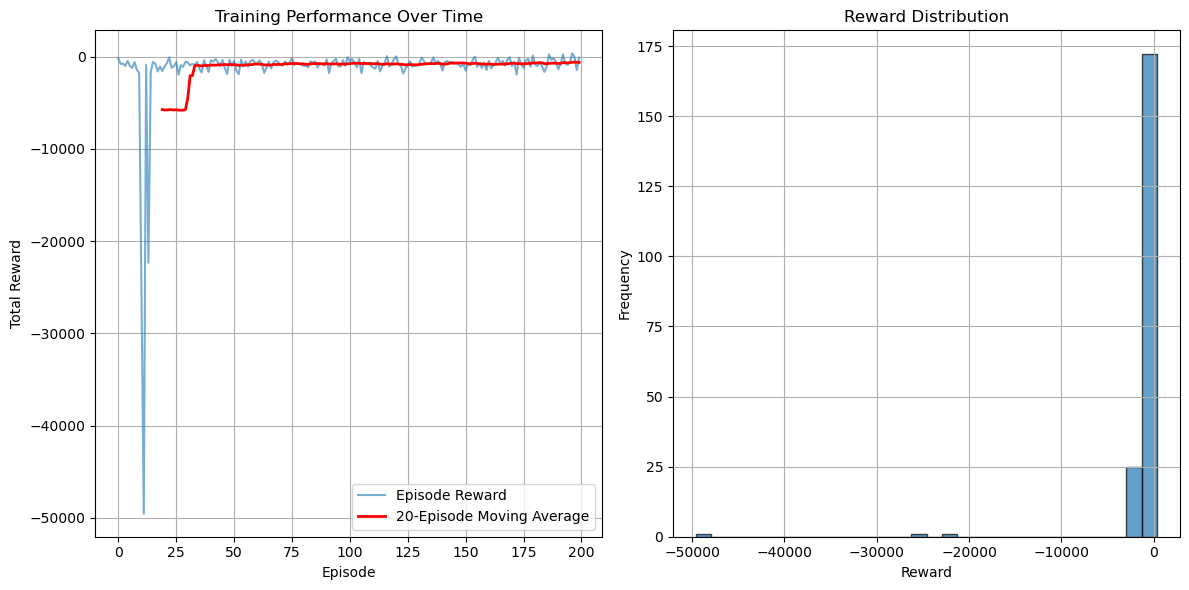

In [53]:
# Reward Curve
env = OptimalExecutionEnv()
trained_policy, rewards = train_dqn(env, episodes=200)
plot_rewards(rewards)
plt.show()  

### **📈 PLOTTING RESULTS**

In [55]:
def plot_rewards(reward_history):
    plt.figure(figsize=(12, 6))
    
    # Plot raw rewards
    plt.subplot(1, 2, 1)
    plt.plot(reward_history, alpha=0.6, label='Episode Reward')
    
    # Plot moving average
    window = 20
    if len(reward_history) >= window:
        moving_avg = pd.Series(reward_history).rolling(window=window).mean()
        plt.plot(moving_avg, color='red', linewidth=2, label=f'{window}-Episode Moving Average')
    
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Performance Over Time")
    plt.grid(True)
    plt.legend()
    
    # Plot reward distribution
    plt.subplot(1, 2, 2)
    plt.hist(reward_history, bins=30, alpha=0.7, edgecolor='black')
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.title("Reward Distribution")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

### **MODEL TRAINING DQN AGENT**

In [76]:
env = OptimalExecutionEnv()
print("Training DQN agent...")
trained_policy, rewards = train_dqn(env, episodes=200)

Training DQN agent...
Episode 0, Reward: -626.14, Epsilon: 0.9510
Episode 20, Reward: -208.40, Epsilon: 0.0200
Episode 40, Reward: -652.61, Epsilon: 0.0200
Episode 60, Reward: -1115.92, Epsilon: 0.0200
Episode 80, Reward: -466.43, Epsilon: 0.0200
Episode 100, Reward: -156.73, Epsilon: 0.0200
Episode 120, Reward: -879.59, Epsilon: 0.0200
Episode 140, Reward: -519.88, Epsilon: 0.0200
Episode 160, Reward: -856.62, Epsilon: 0.0200
Episode 180, Reward: -1085.58, Epsilon: 0.0200


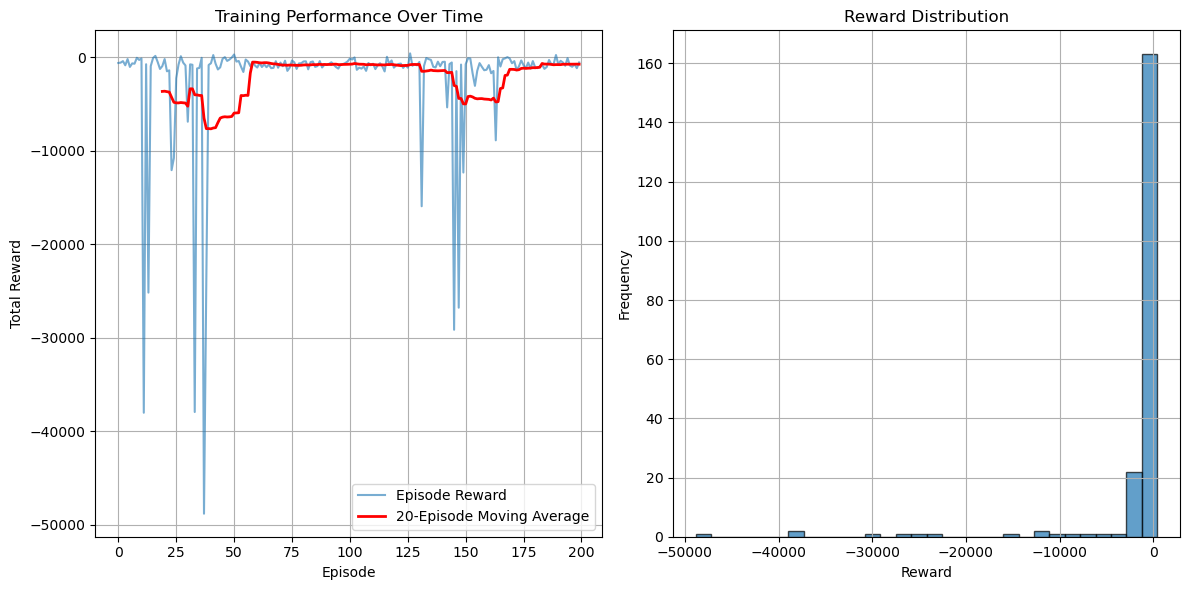

In [77]:
# Plot the training results
plot_rewards(rewards)
plt.show()

### **BASELINE STRATEGIES**

In [79]:
# TWAP Strategy
def run_twap_strategy(env, order_size=MAX_ORDER_SIZE, duration=MAX_TIME_SECONDS):
    state = env.reset()
    steps = duration
    shares_per_step = max(1, order_size // steps)
    total_reward = 0
    
    for step in range(steps):
        if env.inventory <= 0:
            break
        
        # Convert shares to action (ensuring we don't exceed available actions)
        action_size = min(shares_per_step, env.inventory)
        action = min(4, max(1, action_size // Q_MIN))  # Convert to action space
        
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

In [80]:
#Passive strategy
def run_passive_strategy(env):
    state = env.reset()
    total_reward = 0
    
    while True:
        if random.random() < 0.6:
            action = 0  # do nothing
        else:
            action = random.randint(1, 4)
        
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

In [81]:
# Aggressive Strategy
def run_aggressive_strategy(env):
    state = env.reset()
    total_reward = 0
    
    while True:
        action = 2  # Always buy 2 × Qmin
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

In [82]:
# Random Strategy
def run_random_strategy(env):
    state = env.reset()
    total_reward = 0
    
    while True:
        action = random.randint(0, 4)
        _, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
    return total_reward

### **Evaluation and Comparison of All Strategies**

In [84]:
def evaluate_all_strategies(env, trained_agent=None, runs=10):
    results = {
        'TWAP': [],
        'Passive': [],
        'Aggressive': [],
        'Random': [],
        'RL': []
    }

    print("Evaluating strategies...")
    for run in range(runs):
        if run % 5 == 0:
            print(f"Run {run + 1}/{runs}")
            
        results['TWAP'].append(run_twap_strategy(env))
        results['Passive'].append(run_passive_strategy(env))
        results['Aggressive'].append(run_aggressive_strategy(env))
        results['Random'].append(run_random_strategy(env))

        # RL strategy
        if trained_agent is not None:
            state = env.reset()
            total_reward = 0
            done = False
            while not done:
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                with torch.no_grad():
                    action = trained_agent(state_tensor).argmax().item()
                state, reward, done, _ = env.step(action)
                total_reward += reward
            results['RL'].append(total_reward)
        else:
            results['RL'].append(0)  # Placeholder if no trained agent

    return results

### **Plot Baseline Comparison**

In [86]:
def plot_strategy_comparison(results):
    df = pd.DataFrame(results)
    
    plt.figure(figsize=(15, 5))
    
    # Box plot
    plt.subplot(1, 3, 1)
    sns.boxplot(data=df)
    plt.title("Strategy Comparison (Total Reward)")
    plt.ylabel("Reward")
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Summary statistics
    plt.subplot(1, 3, 2)
    means = df.mean()
    stds = df.std()
    plt.errorbar(range(len(means)), means, yerr=stds, fmt='o', capsize=5)
    plt.xticks(range(len(means)), means.index, rotation=45)
    plt.ylabel("Mean Reward ± Std")
    plt.title("Mean Performance with Error Bars")
    plt.grid(True)
    
    # Violin plot
    plt.subplot(1, 3, 3)
    df_melted = df.melt(var_name='Strategy', value_name='Reward')
    sns.violinplot(data=df_melted, x='Strategy', y='Reward')
    plt.xticks(rotation=45)
    plt.title("Reward Distribution by Strategy")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics:")
    print(df.describe())

### **Evaluation Run**

Evaluating strategies...
Run 1/500
Run 6/500
Run 11/500
Run 16/500
Run 21/500
Run 26/500
Run 31/500
Run 36/500
Run 41/500
Run 46/500
Run 51/500
Run 56/500
Run 61/500
Run 66/500
Run 71/500
Run 76/500
Run 81/500
Run 86/500
Run 91/500
Run 96/500
Run 101/500
Run 106/500
Run 111/500
Run 116/500
Run 121/500
Run 126/500
Run 131/500
Run 136/500
Run 141/500
Run 146/500
Run 151/500
Run 156/500
Run 161/500
Run 166/500
Run 171/500
Run 176/500
Run 181/500
Run 186/500
Run 191/500
Run 196/500
Run 201/500
Run 206/500
Run 211/500
Run 216/500
Run 221/500
Run 226/500
Run 231/500
Run 236/500
Run 241/500
Run 246/500
Run 251/500
Run 256/500
Run 261/500
Run 266/500
Run 271/500
Run 276/500
Run 281/500
Run 286/500
Run 291/500
Run 296/500
Run 301/500
Run 306/500
Run 311/500
Run 316/500
Run 321/500
Run 326/500
Run 331/500
Run 336/500
Run 341/500
Run 346/500
Run 351/500
Run 356/500
Run 361/500
Run 366/500
Run 371/500
Run 376/500
Run 381/500
Run 386/500
Run 391/500
Run 396/500
Run 401/500
Run 406/500
Run 411/500
R

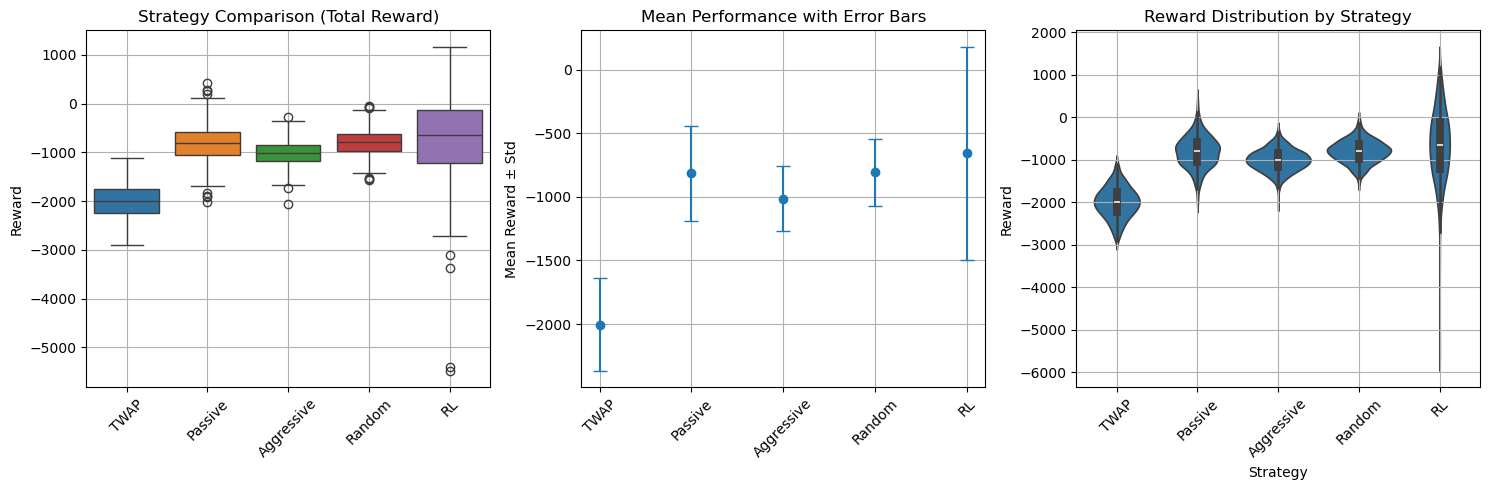


Summary Statistics:
              TWAP      Passive   Aggressive       Random           RL
count   500.000000   500.000000   500.000000   500.000000   500.000000
mean  -2003.629898  -812.331714 -1012.335846  -805.829650  -657.090249
std     363.992226   373.518254   256.349895   264.393637   840.150336
min   -2906.151153 -2020.368787 -2061.698664 -1563.883196 -5482.826607
25%   -2237.920099 -1060.257021 -1185.366835  -980.677371 -1213.128021
50%   -1995.922711  -802.730484 -1010.228984  -791.440763  -646.987076
75%   -1760.185271  -582.381595  -839.814633  -628.169064  -119.676333
max   -1109.150472   431.872700  -276.377944   -37.596133  1173.566196


In [88]:
# Evaluate all strategies and compare performance
baseline_results = evaluate_all_strategies(env, trained_agent=trained_policy, runs=500)
plot_strategy_comparison(baseline_results)